# Exploring Two Decades of Brazilian Commercial Flights with SQL + DuckDB  

Commercial aviation is a critical component of Brazil’s economy and logistics network: in 2014 alone it carried **95.9 million passengers and ranked 1st in Latin America by Revenue-Passenger-Kilometres** (Teixeira et al., 2021; International Civil Aviation Organization [ICAO], 2015).  
To help researchers and practitioners analyse this system, Teixeira et al. (2021) released the **Integrated Brazilian Flight Dataset (BFD)**—14.7 million flight records from **2000 to 2023**, enriched with airport-level weather observations.

In this notebook I use **DuckDB-in-Python** to query the 54-column parquet table entirely in SQL and visualise the results with Matplotlib.  
The analysis answers four business-driven questions:

1. **Traffic growth** – How has air traffic evolved since 2000?  
2. **Network structure** – Which airports and city-pairs dominate the network?  
3. **Operational patterns** – What time-of-day and seasonal schedules do airlines follow?  
4. **Service quality** – Where do delays cluster, and which airlines perform best (and worst)?

Along the way you’ll see examples of:

* Efficiently scanning a parquet file with DuckDB’s vectorised engine  
* Writing expressive SQL for window functions, CTEs and ranking  
* Converting query results directly to Pandas (zero-copy) for plotting  
* Communicating findings with concise, publication-quality charts


In [1]:
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
con = duckdb.connect()

In [3]:
# Reading parquet file
query = """
    SELECT * 
    FROM read_parquet('bfd_complete_2000_2023.parquet')
    LIMIT 5;
"""
result = con.execute(query).fetchdf()

In [4]:
result

,arrival,depart,route,company,flight,di,type,expected_depart,real_depart,expected_arrival,real_arrival,status,observation,delay_depart,delay_arrival,expected_flight_length,real_flight_length,outlier_depart_delay,outlier_arrival_delay,outlier_expected_flight_consistency,outlier_real_flight_consistency,outlier_expected_flight_length,outlier_real_flight_length,depart_lon,depart_lat,depart_elevation,depart_air_temperature,depart_dew_point,depart_relative_humidity,depart_wind_direction,depart_wind_speed,depart_sky_coverage,depart_pressure,depart_visibility,depart_apparent_temperature,depart_wind_speed_scale,depart_wind_direction_cat,depart_day_period,arrival_lon,arrival_lat,arrival_elevation,arrival_air_temperature,arrival_dew_point,arrival_relative_humidity,arrival_wind_direction,arrival_wind_speed,arrival_sky_coverage,arrival_pressure,arrival_visibility,arrival_apparent_temperature,arrival_wind_speed_scale,arrival_wind_direction_cat,arrival_day_period,year
0,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-01 13:45:00-02:00,NaT,2000-01-01 16:10:00-02:00,NaT,Cancelado,XN,NaN,NaN,145.0,NaN,<NA>,<NA>,False,<NA>,False,<NA>,-37.0703,-10.984,9.0,29.0,23.0,70.08,100.0,8.0,None,29.80,7.0,32.744444,Gentle Breeze,E,Afternoon,-43.2437,-22.8089,6.0,25.0,25.0,100.00,130.0,2.0,None,29.71,4.0,25.000000,Light Air,SE,Afternoon,2000
1,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-02 13:45:00-02:00,2000-01-02 13:45:00-02:00,2000-01-02 16:10:00-02:00,2000-01-02 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,30.0,24.0,70.27,120.0,6.0,None,29.80,7.0,35.105556,Light Breeze,ESE,Afternoon,-43.2437,-22.8089,6.0,24.0,24.0,100.00,170.0,3.0,None,29.74,4.0,25.066667,Light Air,S,Afternoon,2000
2,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-03 13:45:00-02:00,2000-01-03 13:45:00-02:00,2000-01-03 16:10:00-02:00,2000-01-03 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,29.0,25.0,79.04,100.0,11.0,None,29.80,7.0,34.533333,Moderate Breeze,E,Afternoon,-43.2437,-22.8089,6.0,25.0,24.0,94.19,150.0,6.0,None,29.71,5.0,26.016667,Light Breeze,SSE,Afternoon,2000
3,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-04 13:45:00-02:00,2000-01-04 13:45:00-02:00,2000-01-04 16:10:00-02:00,2000-01-04 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,26.0,22.0,78.62,120.0,6.0,None,29.85,7.0,27.611111,Light Breeze,ESE,Afternoon,-43.2437,-22.8089,6.0,31.0,26.0,83.88,350.0,2.0,None,29.83,7.0,37.733333,Light Air,N,Afternoon,2000
4,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-05 13:45:00-02:00,2000-01-05 13:45:00-02:00,2000-01-05 16:10:00-02:00,2000-01-05 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,26.0,23.0,83.55,70.0,4.0,None,29.85,7.0,27.794444,Light Breeze,ENE,Afternoon,-43.2437,-22.8089,6.0,33.0,25.0,62.90,140.0,6.0,None,29.83,7.0,40.588889,Light Breeze,SE,Afternoon,2000


In [5]:
# Registering it as a table for multiple queries
con.execute("""
    CREATE TABLE flights AS 
    SELECT * FROM read_parquet('bfd_complete_2000_2023.parquet');
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
total_rows = con.execute("""
    SELECT COUNT(*) AS total_rows 
    FROM flights;
""").fetchdf().iloc[0, 0]

print(f"Total number of rows: {total_rows}")


total_columns = con.execute("""
    SELECT COUNT(*) AS total_columns 
    FROM pragma_table_info('flights');
""").fetchdf().iloc[0, 0]

print(f"Total number of columns: {total_columns}")

Total number of rows: 14696088
Total number of columns: 54


### Exploratory Data Analysis (EDA) Key Business Questions:
- What are the busiest airports and routes in Brazil?
- How has air traffic evolved from 2000 to 2019?
- What is the distribution of flight types (National, International, Cargo)?
- What are the peak hours and seasons for Brazilian flights?

In [7]:
year_list = con.execute("""

SELECT
       year,
       COUNT(*) AS year_count
FROM flights
WHERE status = 'Realizado'
GROUP BY year
ORDER BY year DESC;
                   
""").fetchdf()

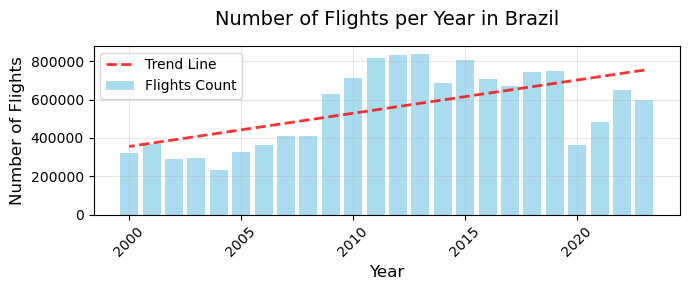

In [ ]:
plt.figure(figsize=(7, 3))

plt.bar(year_list['year'], year_list['year_count'], color='skyblue', alpha=0.7)

# Trend line
z = np.polyfit(year_list['year'], year_list['year_count'], 1)
p = np.poly1d(z)
plt.plot(year_list['year'], p(year_list['year']), "r--", alpha=0.8, linewidth=2)

plt.title('Number of Flights per Year in Brazil', fontsize=14, pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)

plt.legend(['Trend Line', 'Flights Count'])

plt.tight_layout()

plt.show()

This graph shows the evolution of the number of flights in Brazil, with peak years in 2011-2013 and 2015. The COVID-19 pandemic caused a significant drop in flight demand by half in 2020. Since then, the demand has been growing but has not yet reached its pre-COVID levels.

In [9]:
busy_airports = con.execute("""

SELECT
    airport,
    SUM(depart_count) AS depart_count,
    SUM(arrival_count) AS arrival_count,
    SUM(depart_count + arrival_count) AS total_movements
FROM (
    SELECT
       depart AS airport,
       COUNT(*) AS depart_count,
       0 AS arrival_count
    FROM flights
    WHERE status = 'Realizado'
    GROUP BY depart
    
    UNION ALL
       
    SELECT
       arrival AS airport,
       0 AS depart_count,
       COUNT(*) AS arrival_count
    FROM flights
    WHERE status = 'Realizado'
    GROUP BY arrival) subquery
GROUP BY airport
ORDER BY total_movements DESC
LIMIT 10;
""").fetchdf()

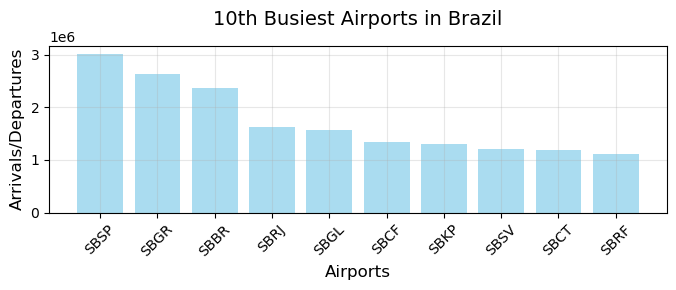

In [10]:
plt.figure(figsize=(7, 3))

plt.bar(busy_airports['airport'], busy_airports['total_movements'], color='skyblue', alpha=0.7)

plt.title('10th Busiest Airports in Brazil', fontsize=14, pad=15)
plt.xlabel('Airports', fontsize=12)
plt.ylabel('Arrivals/Departures', fontsize=12)
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

The busiest airports are: 
1 - São Paulo / Congonhas, 
2 - São Paulo / Guarulhos, 
3 - Brasília, followed by the two airports in the city of Rio de Janeiro.

In [11]:
busy_routes = con.execute("""
       
SELECT
       route,
       COUNT(*) AS route_count
FROM flights
WHERE status = 'Realizado'
GROUP BY route
ORDER BY route_count DESC
LIMIT 10;
       
""").fetchdf()

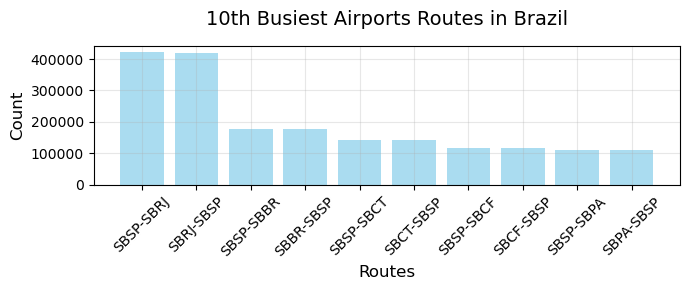

In [12]:
plt.figure(figsize=(7, 3))

plt.bar(busy_routes['route'], busy_routes['route_count'], color='skyblue', alpha=0.7)

plt.title('10th Busiest Airports Routes in Brazil', fontsize=14, pad=15)
plt.xlabel('Routes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

The busiest airport route connects São Paulo (Congonhas/SP) and Rio de Janeiro (Santos Dumont/RJ).

In [13]:
types = con.execute("""

SELECT
    type,
    COUNT(*) AS type_count,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM flights) AS percentage
FROM flights
WHERE status = 'Realizado'
GROUP BY type
ORDER BY percentage DESC
LIMIT 10;
       
""").fetchdf()

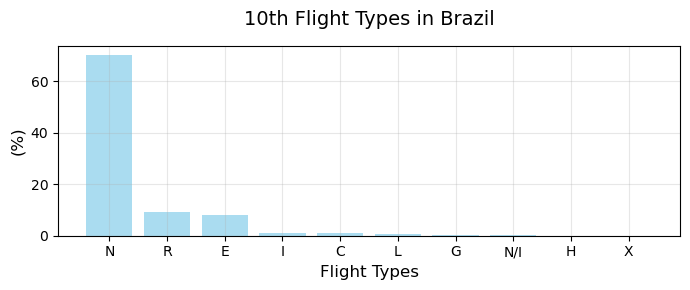

In [14]:
plt.figure(figsize=(7, 3))

plt.bar(types['type'], types['percentage'], color='skyblue', alpha=0.7)

plt.title('10th Flight Types in Brazil', fontsize=14, pad=15)
plt.xlabel('Flight Types', fontsize=12)
plt.ylabel('(%)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

The majority of flights in Brazil are national flights (N), followed by regional flights (R) and special flights (E).

In [15]:
hours = con.execute("""

SELECT
    EXTRACT(HOUR FROM expected_depart) AS hour,
    ROUND(COUNT(*) * 100.0 / 
        (SELECT COUNT(*) FROM flights WHERE status = 'Realizado'), 1) AS percentage
FROM flights
WHERE status = 'Realizado'
GROUP BY hour
ORDER BY hour ASC;

       
""").fetchdf()

In [16]:
periods = con.execute("""

SELECT
    depart_day_period AS period,
    ROUND(COUNT(*) * 100.0 / 
        (SELECT COUNT(*) FROM flights WHERE status = 'Realizado'), 1) AS percentage
FROM flights
WHERE status = 'Realizado'
GROUP BY period
ORDER BY
    CASE period
    WHEN 'Night' THEN 1
    WHEN 'Early Morning' THEN 2
    WHEN 'Mid Morning' THEN 3
    WHEN 'Late Morning' THEN 4
    WHEN 'Afternoon' THEN 5
    WHEN 'Early Evening' THEN 6
    WHEN 'Late Evening' THEN 7
END;
  
""").fetchdf()

In [17]:
months = con.execute("""

SELECT
    EXTRACT(MONTH FROM expected_depart) AS month,
    ROUND(COUNT(*) * 100.0 / 
        (SELECT COUNT(*) FROM flights WHERE status = 'Realizado'), 1) AS percentage
FROM flights
WHERE status = 'Realizado'
GROUP BY month
ORDER BY month ASC;

       
""").fetchdf()

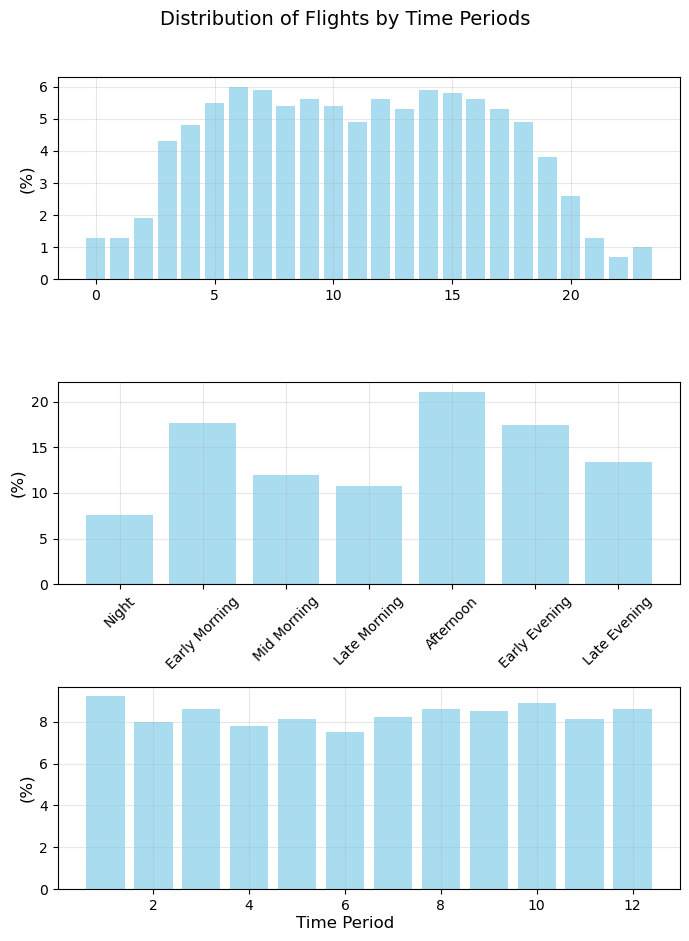

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 9))

fig.suptitle('Distribution of Flights by Time Periods', fontsize=14, y=1.02)

ax1.bar(hours['hour'], hours['percentage'], color='skyblue', alpha=0.7)
ax1.set_ylabel('(%)', fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.bar(periods['period'], periods['percentage'], color='skyblue', alpha=0.7)
ax2.set_ylabel('(%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

ax3.bar(months['month'], months['percentage'], color='skyblue', alpha=0.7)
ax3.set_ylabel('(%)', fontsize=12)
ax3.grid(True, alpha=0.3)

fig.text(0.5, 0, 'Time Period', fontsize=12, ha='center')

plt.tight_layout()
plt.show()

The distribution of flights exhibits peak activity in the early morning (6-7h) and late afternoon hours (14-16h), with the highest percentages occurring during the 'Afternoon' period. Monthly distribution remains relatively stable across the year, indicating no significant seasonal variations in flight activity.

### Delay Analysis Key Business Questions:
- What is the overall punctuality rate of Brazilian flights?
- Which airports experience the most delays?

In [19]:
canceled_df = con.execute("""

SELECT 
    status,
    COUNT(*) AS count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM flights), 2) AS percentage
FROM flights
WHERE status = 'Realizado' OR status = 'Cancelado'
GROUP BY status
ORDER BY percentage DESC;
       
""").fetchdf()

In [20]:
canceled_df.head()

,status,count,percentage
0,Realizado,13316264,90.61
1,Cancelado,1376195,9.36


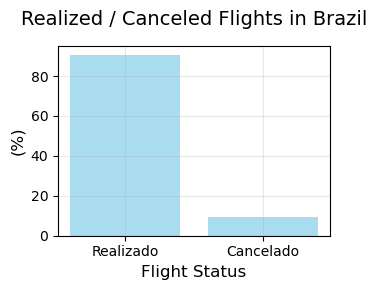

In [21]:
plt.figure(figsize=(3.5, 3))

plt.bar(canceled_df['status'], canceled_df['percentage'], color='skyblue', alpha=0.7)
plt.title('Realized / Canceled Flights in Brazil', fontsize=14, pad=15)
plt.xlabel('Flight Status', fontsize=12)
plt.ylabel('(%)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

Despite the perception that canceled flights represent a significant portion of flights in Brazil, they only constitute 9.36%, compared to 90.61% for realized flights.

In [22]:
delays = con.execute("""
                     
WITH airport_stats AS (
    -- Get total flights per airport
    SELECT 
        airport,
        total_flights,
        delayed_flights,
        ROUND(delayed_flights * 100.0 / total_flights, 2) as delay_rate,
        ROUND(avg_delay_minutes, 2) as avg_delay_minutes
    FROM (
        -- Combining departure and arrival statistics
        SELECT 
            depart as airport,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_depart > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_depart > 0 THEN delay_depart ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY depart
        
        UNION ALL
        
        SELECT 
            arrival as airport,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_arrival > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_arrival > 0 THEN delay_arrival ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY arrival
    )
    GROUP BY airport, total_flights, delayed_flights, avg_delay_minutes
    -- Filtering airports with few flights for statistical significance
    HAVING total_flights >= 1000
)
SELECT 
    airport,
    total_flights,
    delayed_flights,
    delay_rate as delay_percentage,
    avg_delay_minutes,
    RANK() OVER (ORDER BY delay_rate DESC) as delay_rank
FROM airport_stats
ORDER BY delay_rate DESC
LIMIT 10;
""").fetchdf()

delays

,airport,total_flights,delayed_flights,delay_percentage,avg_delay_minutes,delay_rank
0,SBUY,1108,808,72.92,63.58,1
1,SBJR,1333,797,59.79,29.23,2
2,SBUG,1538,674,43.82,44.40,3
3,SBJR,1384,580,41.91,34.54,4
4,SBMD,1198,495,41.32,70.44,5
5,SBBU,2705,1092,40.37,42.02,6
6,SBMD,1502,598,39.81,72.66,7
7,SBNM,1305,499,38.24,39.11,8
8,SBBW,1068,370,34.64,37.58,9
9,SBBV,25654,8713,33.96,13342.06,10


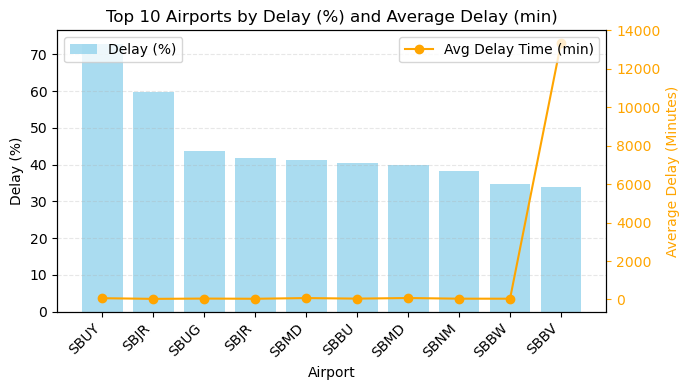

In [23]:
fig, ax1 = plt.subplots(figsize=(7, 4))

x = np.arange(len(delays["airport"]))

ax1.bar(x, delays["delay_percentage"], color='skyblue', alpha=0.7, label='Delay (%)')
ax1.set_xlabel('Airport')
ax1.set_xticks(x)
ax1.set_xticklabels(delays["airport"], rotation=45, ha='right')
ax1.set_ylabel('Delay (%)')
ax1.set_title('Top 10 Airports by Delay (%) and Average Delay (min)')
ax1.grid(alpha=0.3, linestyle='--', axis='y')

ax2 = ax1.twinx()
ax2.plot(x, delays["avg_delay_minutes"], marker='o', color='orange', label='Avg Delay Time (min)')
ax2.set_ylabel('Average Delay (Minutes)', color='orange')
ax2.tick_params(axis='y', colors='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The top 2 airports with the highest delay percentages are Urucu Airport (SBUY) with 72.92%, a small regional airport in the state of Amazonas, and Jacarepaguá Airport (SBRJ) with 59.79%, a regional airport in the state of Rio de Janeiro. The airport with the highest average delay time in minutes is Boa Vista Airport, a medium-sized international airport in the state of Roraima, with an average delay time of 13342.06 minutes (~222 hours). This metric may be influenced by an outlier.

### Operational Efficiency Analysis Key Business Questions:
- What is the average flight duration?
- Which airlines have the best operational performance?

In [24]:
result

,arrival,depart,route,company,flight,di,type,expected_depart,real_depart,expected_arrival,real_arrival,status,observation,delay_depart,delay_arrival,expected_flight_length,real_flight_length,outlier_depart_delay,outlier_arrival_delay,outlier_expected_flight_consistency,outlier_real_flight_consistency,outlier_expected_flight_length,outlier_real_flight_length,depart_lon,depart_lat,depart_elevation,depart_air_temperature,depart_dew_point,depart_relative_humidity,depart_wind_direction,depart_wind_speed,depart_sky_coverage,depart_pressure,depart_visibility,depart_apparent_temperature,depart_wind_speed_scale,depart_wind_direction_cat,depart_day_period,arrival_lon,arrival_lat,arrival_elevation,arrival_air_temperature,arrival_dew_point,arrival_relative_humidity,arrival_wind_direction,arrival_wind_speed,arrival_sky_coverage,arrival_pressure,arrival_visibility,arrival_apparent_temperature,arrival_wind_speed_scale,arrival_wind_direction_cat,arrival_day_period,year
0,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-01 13:45:00-02:00,NaT,2000-01-01 16:10:00-02:00,NaT,Cancelado,XN,NaN,NaN,145.0,NaN,<NA>,<NA>,False,<NA>,False,<NA>,-37.0703,-10.984,9.0,29.0,23.0,70.08,100.0,8.0,None,29.80,7.0,32.744444,Gentle Breeze,E,Afternoon,-43.2437,-22.8089,6.0,25.0,25.0,100.00,130.0,2.0,None,29.71,4.0,25.000000,Light Air,SE,Afternoon,2000
1,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-02 13:45:00-02:00,2000-01-02 13:45:00-02:00,2000-01-02 16:10:00-02:00,2000-01-02 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,30.0,24.0,70.27,120.0,6.0,None,29.80,7.0,35.105556,Light Breeze,ESE,Afternoon,-43.2437,-22.8089,6.0,24.0,24.0,100.00,170.0,3.0,None,29.74,4.0,25.066667,Light Air,S,Afternoon,2000
2,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-03 13:45:00-02:00,2000-01-03 13:45:00-02:00,2000-01-03 16:10:00-02:00,2000-01-03 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,29.0,25.0,79.04,100.0,11.0,None,29.80,7.0,34.533333,Moderate Breeze,E,Afternoon,-43.2437,-22.8089,6.0,25.0,24.0,94.19,150.0,6.0,None,29.71,5.0,26.016667,Light Breeze,SSE,Afternoon,2000
3,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-04 13:45:00-02:00,2000-01-04 13:45:00-02:00,2000-01-04 16:10:00-02:00,2000-01-04 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,26.0,22.0,78.62,120.0,6.0,None,29.85,7.0,27.611111,Light Breeze,ESE,Afternoon,-43.2437,-22.8089,6.0,31.0,26.0,83.88,350.0,2.0,None,29.83,7.0,37.733333,Light Air,N,Afternoon,2000
4,SBGL,SBAR,SBAR-SBGL,VRG,3470,0,N,2000-01-05 13:45:00-02:00,2000-01-05 13:45:00-02:00,2000-01-05 16:10:00-02:00,2000-01-05 16:10:00-02:00,Realizado,None,0.0,0.0,145.0,145.0,False,False,False,False,False,False,-37.0703,-10.984,9.0,26.0,23.0,83.55,70.0,4.0,None,29.85,7.0,27.794444,Light Breeze,ENE,Afternoon,-43.2437,-22.8089,6.0,33.0,25.0,62.90,140.0,6.0,None,29.83,7.0,40.588889,Light Breeze,SE,Afternoon,2000


In [25]:
avg_flight_length = con.execute("""
                     
SELECT
    AVG (real_flight_length) AS avg_flight_length
FROM flights;
                     
""").fetchdf()

In [26]:
avg_length = avg_flight_length["avg_flight_length"].iloc[0]

print(f"Average flight duration: {avg_length:.2f} minutes")

Average flight duration: 103.66 minutes


This result corroborates with the graph of flight types in Brazil. Since most of the flights are national, cargo, and regional, 103 minutes is reasonable.

In [27]:
least_efficient_airlines = con.execute("""
                                  
WITH airport_stats AS (
    SELECT
        company,
        SUM(total_flights) as total_flights,
        SUM(delayed_flights) as delayed_flights,
        ROUND(SUM(delayed_flights) * 100.0 / SUM(total_flights), 2) as delay_rate,
        ROUND(SUM(total_flights * avg_delay_minutes) / SUM(total_flights), 2) as avg_delay_minutes
    FROM (
        SELECT
            company,
            type,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_depart > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_depart > 0 THEN delay_depart ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY company, type
        
        UNION ALL
        
        SELECT
            company,
            type,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_arrival > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_arrival > 0 THEN delay_arrival ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY company, type
    ) AS flight_data
    GROUP BY company
    HAVING SUM(total_flights) >= 1000
),
most_common_type AS (
    SELECT 
        company,
        type,
        RANK() OVER (PARTITION BY company ORDER BY COUNT(*) DESC) as type_rank
    FROM flights
    WHERE status = 'Realizado'
    GROUP BY company, type
)
SELECT 
    a.company,
    a.total_flights,
    a.delay_rate as delay_percentage,
    a.avg_delay_minutes,
    m.type as most_common_type,
    RANK() OVER (ORDER BY a.delay_rate DESC) as delay_rank
FROM airport_stats a
LEFT JOIN most_common_type m ON a.company = m.company AND m.type_rank = 1
ORDER BY delay_rate DESC
LIMIT 10;
""").fetchdf()

least_efficient_airlines

,company,total_flights,delay_percentage,avg_delay_minutes,most_common_type,delay_rank
0,MAA,1130.0,81.24,601.87,G,1
1,IPM,3190.0,73.57,194.84,N,2
2,CLX,6914.0,58.65,284.39,G,3
3,LAE,1332.0,53.98,261.83,G,4
4,LTG,17574.0,53.24,171.75,C,5
5,MST,1086.0,49.63,323.05,C,6
6,SID,52012.0,48.12,49.62,C,7
7,ACN,16800.0,44.85,41.43,N,8
8,TPA,1842.0,44.08,218.53,G,9
9,LCO,1032.0,42.83,497.09,G,10


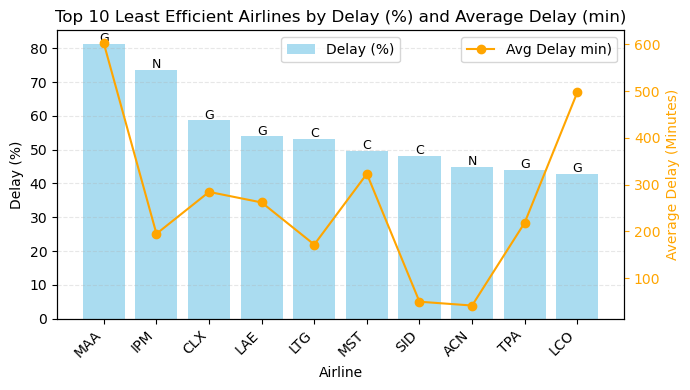

In [28]:
fig, ax1 = plt.subplots(figsize=(7, 4))

x = np.arange(len(least_efficient_airlines["company"]))

ax1.bar(x, least_efficient_airlines["delay_percentage"], color='skyblue', alpha=0.7, label='Delay (%)')
ax1.set_xlabel('Airline')
ax1.set_xticks(x)
ax1.set_xticklabels(least_efficient_airlines["company"], rotation=45, ha='right')
ax1.set_ylabel('Delay (%)')
ax1.set_title('Top 10 Least Efficient Airlines by Delay (%) and Average Delay (min)')
ax1.grid(alpha=0.3, linestyle='--', axis='y')

for i, (percent, flight_type) in enumerate(zip(least_efficient_airlines["delay_percentage"], least_efficient_airlines["most_common_type"])):
    ax1.text(i, percent + 0.5, flight_type, ha='center', fontsize=9, color='black')

ax2 = ax1.twinx()
ax2.plot(x, least_efficient_airlines["avg_delay_minutes"], marker='o', color='orange', label='Avg Delay min)')
ax2.set_ylabel('Average Delay (Minutes)', color='orange')
ax2.tick_params(axis='y', colors='orange')

ax1.legend(loc='upper center')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

The company codes are under the guidelines of the ICAO (International Civil Aviation Organization). The least efficient company is MasAir (MAA) from México, followed by Shipex (IPM/IPM Europe) from the United Kingdom and Cargolux (CLX) from Luxembourg. MasAir is the least efficient company in the delay % rank and in the average delay (minutes) rank. It is worth noticing that the 10 least efficient airlines operate mostly (N) National, (C) Freight / Cargo, and (G) International Freight / Cargo flights.

In [29]:
most_efficient_airlines = con.execute("""
                                  
WITH airport_stats AS (
    SELECT
        company,
        SUM(total_flights) as total_flights,
        SUM(delayed_flights) as delayed_flights,
        ROUND(SUM(delayed_flights) * 100.0 / SUM(total_flights), 2) as delay_rate,
        ROUND(SUM(total_flights * avg_delay_minutes) / SUM(total_flights), 2) as avg_delay_minutes
    FROM (
        SELECT
            company,
            type,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_depart > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_depart > 0 THEN delay_depart ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY company, type
        
        UNION ALL
        
        SELECT
            company,
            type,
            COUNT(*) as total_flights,
            COUNT(CASE WHEN delay_arrival > 0 THEN 1 END) as delayed_flights,
            AVG(CASE WHEN delay_arrival > 0 THEN delay_arrival ELSE NULL END) as avg_delay_minutes
        FROM flights
        WHERE status = 'Realizado'
        GROUP BY company, type
    ) AS flight_data
    GROUP BY company
    HAVING SUM(total_flights) >= 1000
),
most_common_type AS (
    SELECT 
        company,
        type,
        RANK() OVER (PARTITION BY company ORDER BY COUNT(*) DESC) as type_rank
    FROM flights
    WHERE status = 'Realizado'
    GROUP BY company, type
)
SELECT 
    a.company,
    a.total_flights,
    a.delay_rate as delay_percentage,
    a.avg_delay_minutes,
    m.type as most_common_type,
    RANK() OVER (ORDER BY a.delay_rate ASC) as delay_rank
FROM airport_stats a
LEFT JOIN most_common_type m ON a.company = m.company AND m.type_rank = 1
ORDER BY delay_rate ASC
LIMIT 10;
""").fetchdf()

most_efficient_airlines

,company,total_flights,delay_percentage,avg_delay_minutes,most_common_type,delay_rank
0,AVA,2206.0,0.27,429.94,I,1
1,ABZ,8394.0,2.91,214.78,L,2
2,COA,6598.0,3.05,396.89,I,3
3,FDX,2306.0,7.07,377.65,G,4
4,FYW,1908.0,7.81,36.97,N,5
5,TVJ,8334.0,8.52,345.47,R,6
6,BAW,2772.0,8.69,97.35,I,7
7,AAL,16880.0,9.47,297.34,I,8
8,RLE,39070.0,9.74,1667.00,R,9
9,LAN,8974.0,10.72,86.04,I,10


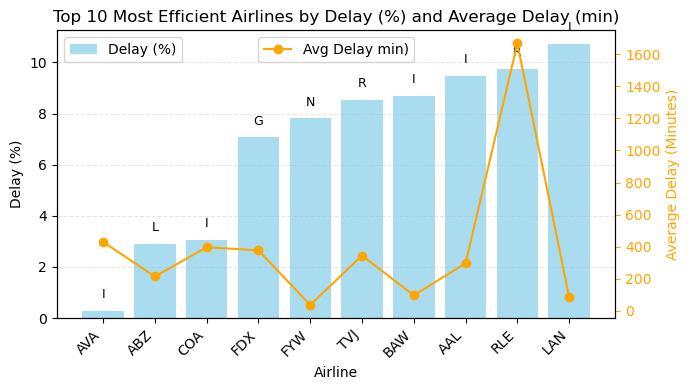

In [30]:
fig, ax1 = plt.subplots(figsize=(7, 4))

x = np.arange(len(most_efficient_airlines["company"]))

ax1.bar(x, most_efficient_airlines["delay_percentage"], color='skyblue', alpha=0.7, label='Delay (%)')
ax1.set_xlabel('Airline')
ax1.set_xticks(x)
ax1.set_xticklabels(most_efficient_airlines["company"], rotation=45, ha='right')
ax1.set_ylabel('Delay (%)')
ax1.set_title('Top 10 Most Efficient Airlines by Delay (%) and Average Delay (min)')
ax1.grid(alpha=0.3, linestyle='--', axis='y')

for i, (percent, flight_type) in enumerate(zip(most_efficient_airlines["delay_percentage"], most_efficient_airlines["most_common_type"])):
    ax1.text(i, percent + 0.5, flight_type, ha='center', fontsize=9, color='black')

ax2 = ax1.twinx()
ax2.plot(x, most_efficient_airlines["avg_delay_minutes"], marker='o', color='orange', label='Avg Delay min)')
ax2.set_ylabel('Average Delay (Minutes)', color='orange')
ax2.tick_params(axis='y', colors='orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

plt.tight_layout()
plt.show()

The most efficient airline company is Avianca (AVA) (0.27% delays) from Colombia, followed by ATA-Brazil (ATA) (2.91% delays) from Brazil, and Continental Airlines (COA) (3.05% delays) from the USA. Among the most efficient companies, the one with the highest average delay is Rico Air Lines (RLE) from Brazil, with an average delay of 1667 minutes. It is worth noticing that, in contrast to the Top 10 least efficient companies, the 10 most efficient airlines operate mostly in (N) National, (I) International, (R) Regional, (G) International Freight / Cargo, and (L) Postal Network.

## Key Insights & Recommended Actions  

| Theme | Insight | Potential Action |
|-------|---------|------------------|
| Traffic trend | Flight volume peaked in **2011–2013** and recovered post-COVID but remains below past highs. | Airlines: adjust capacity planning for a slower rebound; Investors: anticipate upside in underserved segments. |
| Network hubs | **São Paulo (Congonhas & Guarulhos)**, **Brasília**, and **Rio de Janeiro (Galeão & Santos Dumont)** account for the majority of all movements. | Airport operators: prioritise slot allocation and ground-handling resources at these hubs. |
| Peak periods | Departures cluster in the **Afternoon (13-16 h)**; arrivals in **Early Evening**. | ANAC & ATC: stagger slots or incentivise off-peak operations to smooth demand. |
| Delays | Two regional airports—**SBUY (Urucu, AM)** and **SBJR (Jacarepaguá, RJ)**—show delay rates of **60–73 %**; Boa Vista (SBBV) records extreme average delays (likely outliers). | Regional carriers: audit ground processes; ANAC: investigate data quality and enforce reporting standards. |
| Airline efficiency | **Avianca-Colombia, ATA-Brasil and Continental** lead with <4 % delays; **MasAir, Shipex, Cargolux** exceed 30 %. | **Low-performers:** deploy real-time turnaround tracking and predictive maintenance; **Shippers & travel-tech firms:** incorporate on-time metrics into contracts and fare-ranking algorithms to reward reliability. |
| Average stage length | Mean realised flight time ≈ **103 min**, consistent with a domestic-heavy network. | **Revenue managers:** recalibrate pricing buckets for short- vs mid-haul legs; **Airport authorities:** use stage-length data to forecast runway wear and optimise maintenance schedules. |

### What I would explore next

* **Weather-delay causal modelling** using the joined ASOS meteorological fields  
* **Graph analytics** on the origin-destination network to quantify hub centrality and delay propagation  
* **Forecasting** passenger-demand recovery with exogenous variables (GDP, fuel prices, tourism data)

### Take-home message

Leveraging **SQL at scale** lets us move from raw Parquet to actionable aviation insights in minutes, demonstrating a workflow that hiring managers can trust for production analytics.

### Data sources

Teixeira, C. et al. (2020). *Integrated Dataset of Brazilian Flights.* IEEE DataPort. DOI 10.21227/k10b-qn21. 

### References
  
1. Teixeira, C., Giusti, L., Soares, J., dos Santos, J., Amorim, G., & Ogasawara, E. (2021, June). *Integrated dataset of Brazilian flights*. In *Proceedings of the Brazilian e-Science Workshop (BRESCI 2021)*. IEEE.
2. International Civil Aviation Organization. (2015). *Annual report of the Council 2014*. Author.